In [1]:
import requests

hours = 6500
resp = requests.post(f"http://127.0.0.1:8000/incidents/aggregate_counts?hours={hours}")
resp.json()

{'status': 'ok', 'hours': 6500, 'buckets_updated': 80666}

In [ ]:
import os
from pathlib import Path

import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)

# Load backend .env and connect to Supabase
backend_env = Path("../backend/.env")
if backend_env.exists():
    load_dotenv(backend_env)
else:
    load_dotenv()

SUPABASE_DB_URL = os.getenv("SUPABASE_DB_URL")
engine = create_engine(SUPABASE_DB_URL)

query = """
SELECT
    cell_id,
    bucket_start,
    fire_count,
    police_count
FROM incident_counts
ORDER BY bucket_start, cell_id;
"""

counts = pd.read_sql(query, engine, parse_dates=["bucket_start"])
counts.head()


,cell_id,bucket_start,fire_count,police_count
0,373,2010-12-26 02:00:00+00:00,0,1
1,324,2011-01-11 21:00:00+00:00,0,1
2,131,2011-01-14 11:00:00+00:00,0,1
3,322,2011-02-05 01:00:00+00:00,0,1
4,515,2011-09-04 22:00:00+00:00,0,1


In [3]:
hourly_totals = (
    counts
    .groupby("bucket_start", as_index=False)[["fire_count", "police_count"]]
    .sum()
)

hourly_totals["total"] = hourly_totals["fire_count"] + hourly_totals["police_count"]
hourly_totals.head()


,bucket_start,fire_count,police_count,total
0,2010-12-26 02:00:00+00:00,0,1,1
1,2011-01-11 21:00:00+00:00,0,1,1
2,2011-01-14 11:00:00+00:00,0,1,1
3,2011-02-05 01:00:00+00:00,0,1,1
4,2011-09-04 22:00:00+00:00,0,1,1


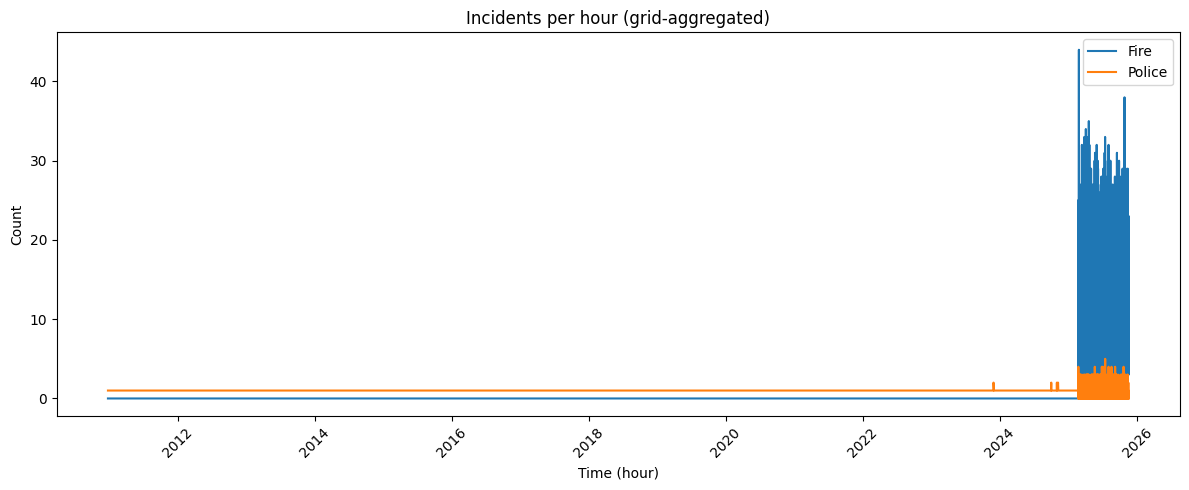

In [4]:
fig, ax = plt.subplots()

ax.plot(hourly_totals["bucket_start"], hourly_totals["fire_count"], label="Fire")
ax.plot(hourly_totals["bucket_start"], hourly_totals["police_count"], label="Police")

ax.set_title("Incidents per hour (grid-aggregated)")
ax.set_xlabel("Time (hour)")
ax.set_ylabel("Count")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


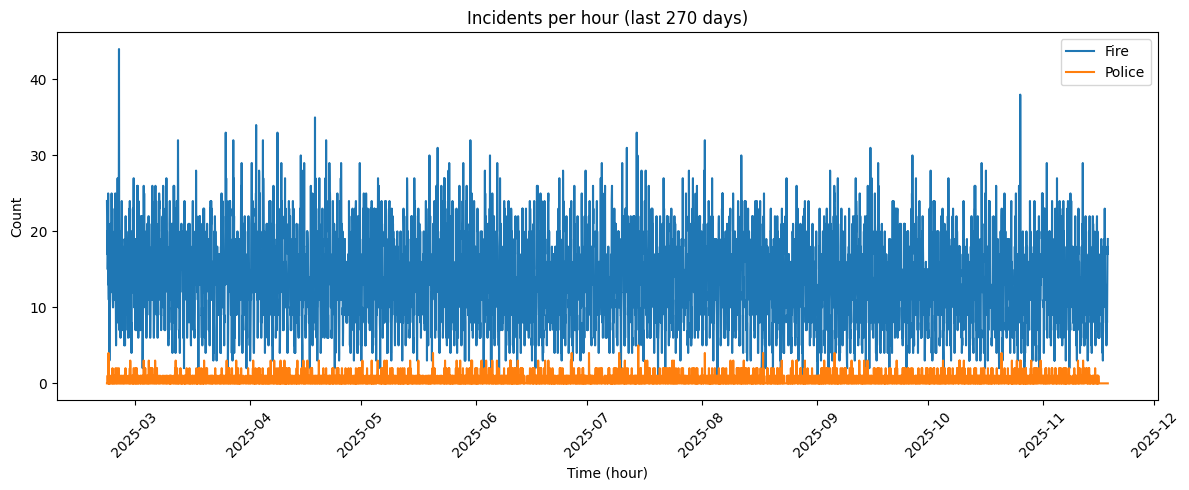

In [6]:
recent = hourly_totals[hourly_totals["bucket_start"] >=
                       hourly_totals["bucket_start"].max() - pd.Timedelta(days=270)]

fig, ax = plt.subplots()
ax.plot(recent["bucket_start"], recent["fire_count"], label="Fire")
ax.plot(recent["bucket_start"], recent["police_count"], label="Police")
ax.set_title("Incidents per hour (last 270 days)")
ax.set_xlabel("Time (hour)")
ax.set_ylabel("Count")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
cell_totals = (
    counts
    .assign(total=lambda d: d["fire_count"] + d["police_count"])
    .groupby("cell_id")["total"]
    .sum()
    .sort_values(ascending=False)
)

top_cell_id = int(cell_totals.index[0])
top_cell_id


299

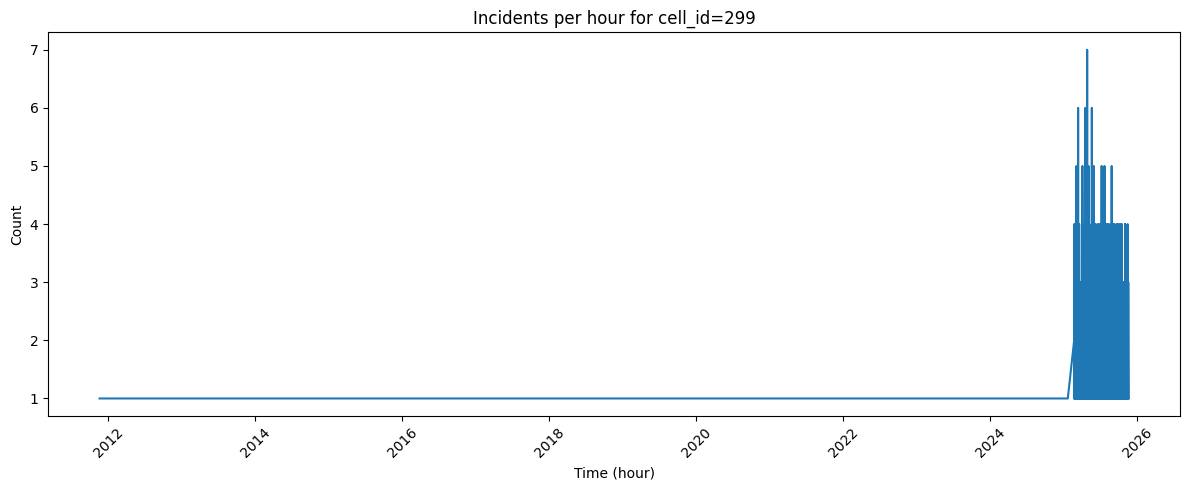

In [8]:
cell_ts = (
    counts[counts["cell_id"] == top_cell_id]
    .sort_values("bucket_start")
    .assign(total=lambda d: d["fire_count"] + d["police_count"])
)

fig, ax = plt.subplots()
ax.plot(cell_ts["bucket_start"], cell_ts["total"])
ax.set_title(f"Incidents per hour for cell_id={top_cell_id}")
ax.set_xlabel("Time (hour)")
ax.set_ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
from pathlib import Path
import os

# connect as before
load_dotenv("../backend/.env")
engine = create_engine(os.getenv("SUPABASE_DB_URL"))

fire_bounds = pd.read_sql(
    "SELECT MIN(ts) AS min_ts FROM fire_incidents;",
    engine,
    parse_dates=["min_ts"],
)
police_bounds = pd.read_sql(
    "SELECT MIN(ts) AS min_ts FROM police_calls;",
    engine,
    parse_dates=["min_ts"],
)

fire_start = fire_bounds["min_ts"][0]
police_start = police_bounds["min_ts"][0]

overlap_start = max(fire_start, police_start)
fire_start, police_start, overlap_start


(Timestamp('2025-01-20 10:24:00+0000', tz='UTC'),
 Timestamp('2009-06-02 08:06:39+0000', tz='UTC'),
 Timestamp('2025-01-20 10:24:00+0000', tz='UTC'))

In [ ]:
# Load everything from incident_counts once
query = """
SELECT cell_id, bucket_start, fire_count, police_count
FROM incident_counts
ORDER BY bucket_start, cell_id;
"""
counts = pd.read_sql(query, engine, parse_dates=["bucket_start"])

# Aggregate over all cells per hour
hourly_totals = (
    counts
    .groupby("bucket_start", as_index=False)[["fire_count", "police_count"]]
    .sum()
)

# Find the first hour where there is at least one fire AND one police call
mask_both = (hourly_totals["fire_count"] > 0) & (hourly_totals["police_count"] > 0)

first_both_row = hourly_totals[mask_both].iloc[0]
start_ts = first_both_row["bucket_start"]

start_ts

Timestamp('2025-02-21 03:00:00+0000', tz='UTC')

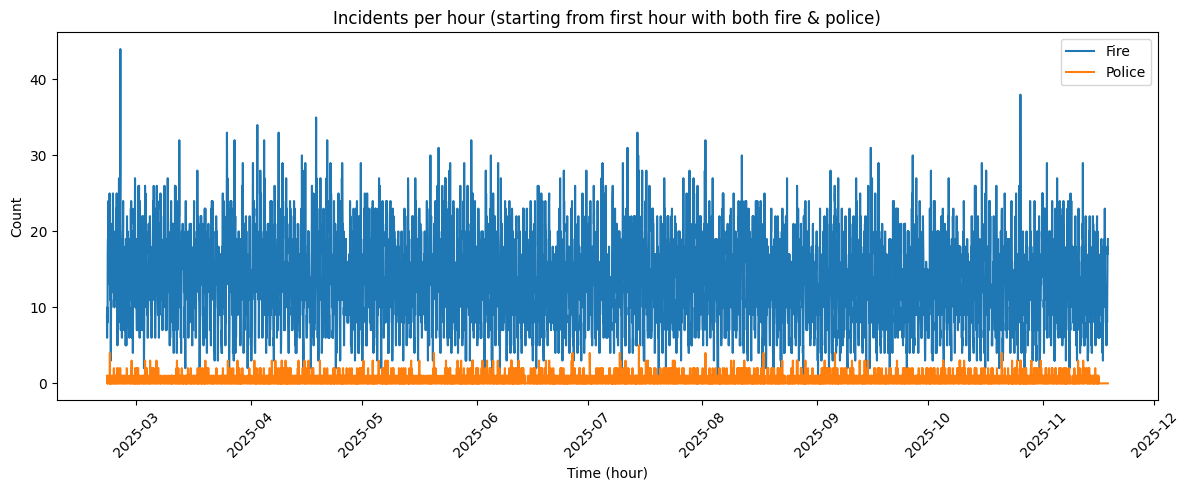

In [16]:
# Only keep rows from that hour onward
counts_cut = counts[counts["bucket_start"] >= start_ts].copy()

hourly_totals_cut = (
    counts_cut
    .groupby("bucket_start", as_index=False)[["fire_count", "police_count"]]
    .sum()
)

fig, ax = plt.subplots()

ax.plot(hourly_totals_cut["bucket_start"],
        hourly_totals_cut["fire_count"],
        label="Fire")

ax.plot(hourly_totals_cut["bucket_start"],
        hourly_totals_cut["police_count"],
        label="Police")

ax.set_title("Incidents per hour (starting from first hour with both fire & police)")
ax.set_xlabel("Time (hour)")
ax.set_ylabel("Count")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()